In [1]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

#Загружаем необходимые нам библиотеки
#библиотеки для моделирования
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

#для разбиения признаков, выборок и сеток для поиска лучших гиперпараметров
from sklearn.model_selection import cross_val_score, train_test_split, KFold, learning_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#библиотеки отбора признаков и оценки их значимости
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2

#оценки качества классификации
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, precision_score, recall_score

# 1. Data preview & analysis

In [2]:
hr = pd.read_csv('heart.csv')

In [3]:
hr.sample(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
784,65,M,TA,138,282,1,LVH,174,N,1.4,Flat,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
344,51,M,ASY,120,0,1,Normal,104,N,0.0,Flat,1
681,51,M,ASY,140,261,0,LVH,186,Y,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0


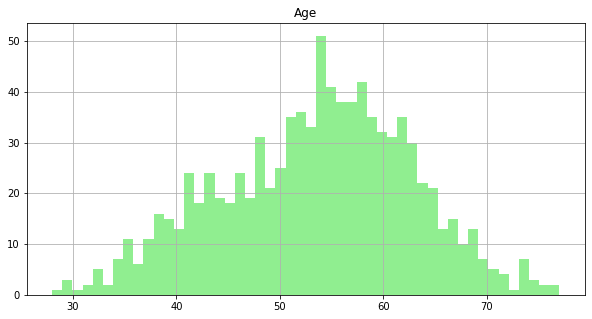

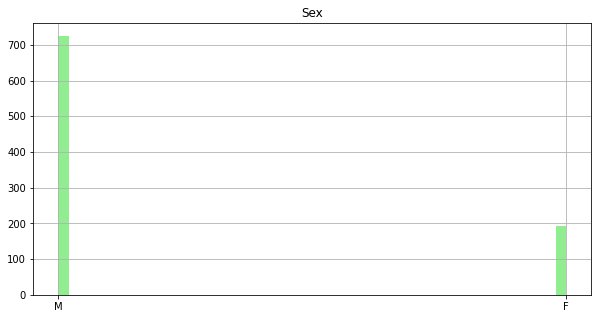

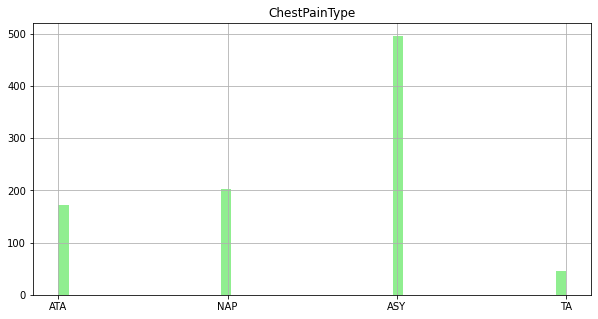

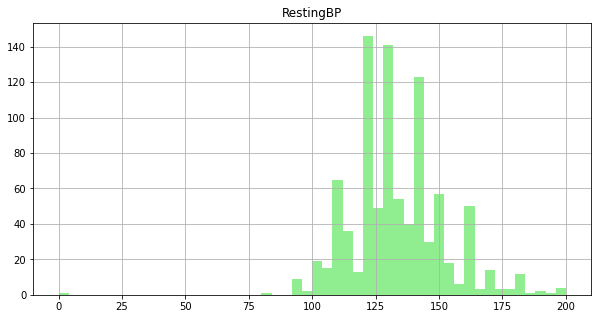

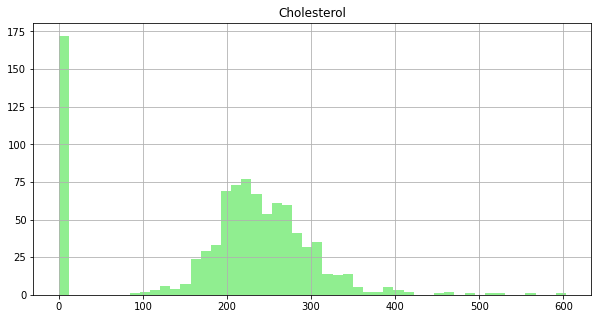

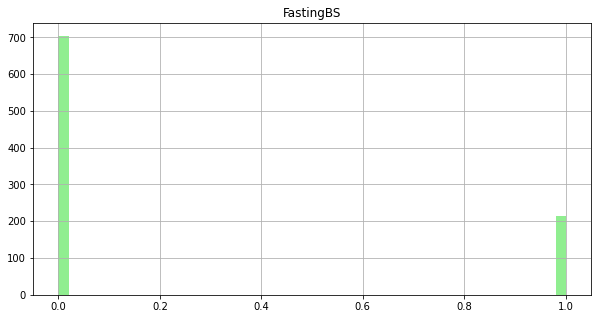

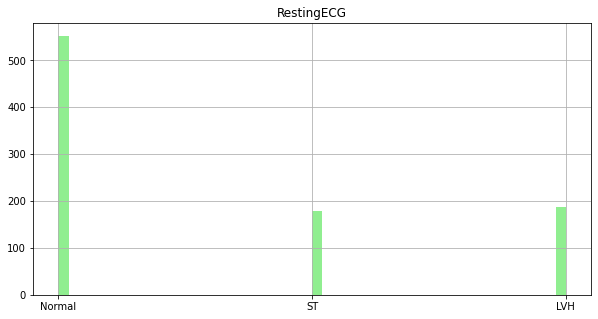

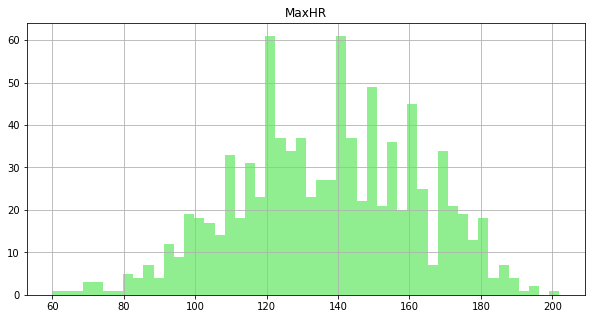

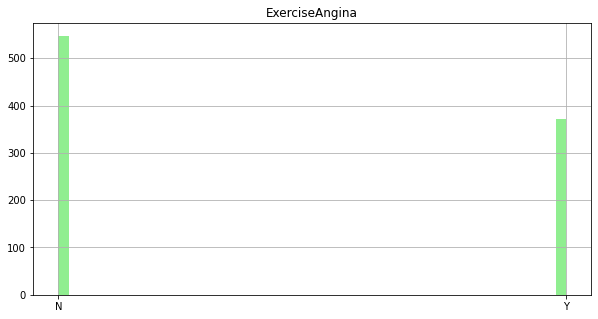

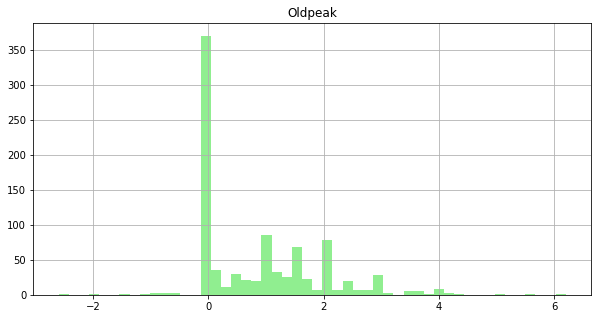

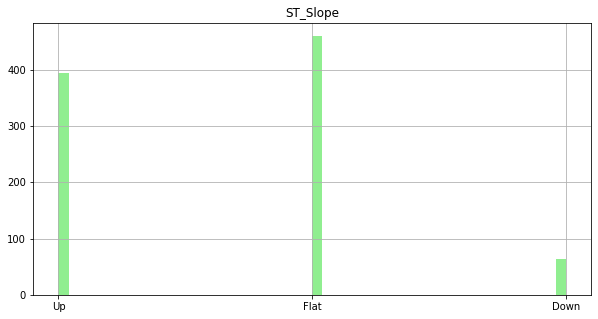

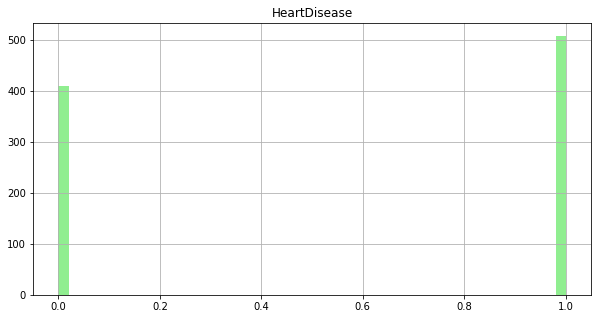

In [4]:
cols = hr.columns

for col in cols:
    plt.figure(figsize=(10, 5))
    plt.title(col)
    hr[col].hist(color='lightgreen', bins=50)

In [5]:
nums = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']
cats = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']

<AxesSubplot:>

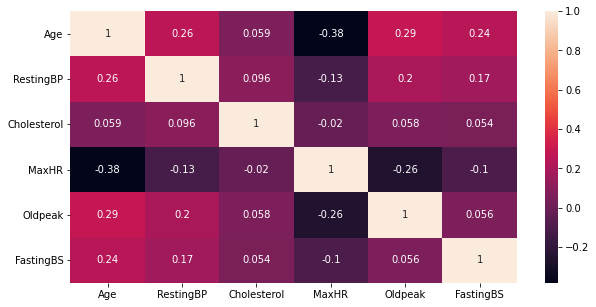

In [6]:
plt.figure(figsize=(10, 5))
sns.heatmap(data=hr[hr.Cholesterol !=0][nums].corr(), annot=True)
#посмотрим на корреляцию численных признаков

In [7]:
reference = {}
for col in cols[:-1]:
    if col in cats:
        reference[col] = hr[col].unique()
    else:
        reference[col] = [f'min: {hr[col].min()}, middle: {np.round(hr[col].mean())}, max: {hr[col].max()}']

In [8]:
print('Словарь данных о пациентах:','', sep='\n')
for key,value in reference.items():
    print(f'{key}: {value}')

Словарь данных о пациентах:

Age: ['min: 28, middle: 54.0, max: 77']
Sex: ['M' 'F']
ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
RestingBP: ['min: 0, middle: 132.0, max: 200']
Cholesterol: ['min: 0, middle: 199.0, max: 603']
FastingBS: ['min: 0, middle: 0.0, max: 1']
RestingECG: ['Normal' 'ST' 'LVH']
MaxHR: ['min: 60, middle: 137.0, max: 202']
ExerciseAngina: ['N' 'Y']
Oldpeak: ['min: -2.6, middle: 1.0, max: 6.2']
ST_Slope: ['Up' 'Flat' 'Down']


# 2. Data preprocessing and feature engineering

In [9]:
def preprocessing_data (data):
    data_processed = pd.get_dummies(data, columns = ['Sex', 'FastingBS', 'ExerciseAngina'])
    
    labelencoder = LabelEncoder()
    
    data_processed['ChestPainType'] = labelencoder.fit_transform(data_processed['ChestPainType'])
    data_processed['RestingECG'] = labelencoder.fit_transform(data_processed['RestingECG'])
    data_processed['ST_Slope'] = labelencoder.fit_transform(data_processed['ST_Slope'])
    
    return data_processed

In [10]:
hr_processed = preprocessing_data(hr)

In [11]:
hr_processed

,Age,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex_F,Sex_M,FastingBS_0,FastingBS_1,ExerciseAngina_N,ExerciseAngina_Y
0,40,1,140,289,1,172,0.0,2,0,0,1,1,0,1,0
1,49,2,160,180,1,156,1.0,1,1,1,0,1,0,1,0
2,37,1,130,283,2,98,0.0,2,0,0,1,1,0,1,0
3,48,0,138,214,1,108,1.5,1,1,1,0,1,0,0,1
4,54,2,150,195,1,122,0.0,2,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,3,110,264,1,132,1.2,1,1,0,1,1,0,1,0
914,68,0,144,193,1,141,3.4,1,1,0,1,0,1,1,0
915,57,0,130,131,1,115,1.2,1,1,0,1,1,0,0,1
916,57,1,130,236,0,174,0.0,1,1,1,0,1,0,1,0


In [12]:
#сделаем сет для Хи квадрат теста и сам тест
X_select = hr_processed[hr_processed.Cholesterol != 0].drop(nums[:-1], axis=1).values
y_select = hr_processed[hr_processed.Cholesterol != 0].Cholesterol.values

chi2(X_select,y_select)[0]

array([228.59539908,  93.24088407,  54.01013619, 123.64150555,
       158.27843704,  51.07566585,  37.57520791, 186.6736329 ,
        84.4677321 , 135.08950883])

In [13]:
#Холестерин имеет много нулевых значений
#заполним их алгоритмом машинного обучения по другим признакам
#Выберем первые 4 признака с максимальным значением Хи квадрат: ChestPainType, Sex_F, FastingBS_1, ExerciseAngina_Y
chol = ['ChestPainType', 'Sex_F', 'FastingBS_1', 'ExerciseAngina_Y']

#тренировочный сет для K-соседей, стандартизируем признаки
X_k_train = hr_processed[hr_processed.Cholesterol != 0][chol].values

#тестовый сет для K-соседей, стандартизируем признаки
X_k_pred = hr_processed[hr_processed.Cholesterol == 0][chol].values

In [14]:
y_select.shape, X_k_train.shape, X_k_pred.shape

((746,), (746, 4), (172, 4))

In [15]:
clusterer = KNeighborsRegressor(n_neighbors = 7, weights='distance') #создаем экземпляр модели с 7-ю соседями
clusterer.fit(X_k_train,y_select) #тренируем модель

y_pred = clusterer.predict(X_k_pred)# делаем предсказание холестерина
y_pred_df = pd.DataFrame(data=y_pred, columns=['Cholesterol_pred']) #создаем даатфрейм с колонкой прогнозных значений

hr_processed.loc[(hr_processed['Cholesterol'] ==0), 'Cholesterol'] = y_pred_df['Cholesterol_pred'].values #меняем нули в колонке tax на прогнозные значения
hr_processed.sample(10)

,Age,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex_F,Sex_M,FastingBS_0,FastingBS_1,ExerciseAngina_N,ExerciseAngina_Y
38,48,1,120,177.000000,2,148,0.0,2,0,1,0,0,1,1,0
819,55,0,160,289.000000,0,145,0.8,1,1,0,1,1,0,0,1
129,42,2,120,228.000000,1,152,1.5,1,0,0,1,1,0,0,1
1,49,2,160,180.000000,1,156,1.0,1,1,1,0,1,0,1,0
512,35,2,123,161.000000,2,153,-0.1,2,0,0,1,1,0,1,0
254,55,0,145,248.000000,1,96,2.0,1,1,0,1,1,0,0,1
378,70,0,140,327.285714,1,157,2.0,1,1,0,1,0,1,0,1
679,63,3,145,233.000000,0,150,2.3,0,0,0,1,0,1,1,0
28,53,1,113,468.000000,1,127,0.0,2,0,1,0,1,0,1,0
726,41,1,110,235.000000,1,153,0.0,2,0,0,1,1,0,1,0


<AxesSubplot:title={'center':'Cholesterol'}>

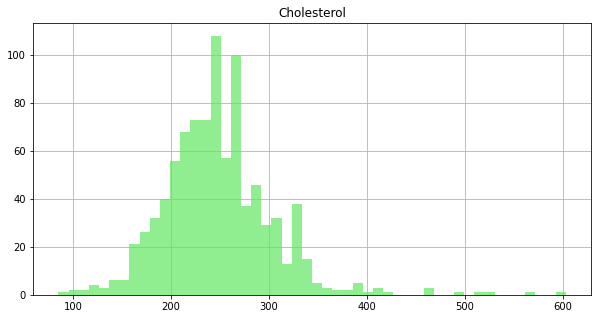

In [16]:
plt.figure(figsize=(10, 5))
plt.title('Cholesterol')
hr_processed['Cholesterol'].hist(color='lightgreen', bins=50)

# 3. Modeling

In [17]:
RANDOM_SEED = 42

In [18]:
X = hr_processed.drop('HeartDisease', axis=1).values
y = hr_processed.HeartDisease.values

In [19]:
#разобьем данные на тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((642, 14), (276, 14), (642,), (276,))

In [39]:
clf_etree = ExtraTreesClassifier(random_state=RANDOM_SEED,
                                      n_estimators = 500,
                                      n_jobs=-1)
model_extree = clf_etree.fit(X_train, y_train)
y_pred = model_extree.predict(X_test)
y_proba = model_extree.predict_proba(X_test)[:,1]

In [40]:
def print_regression_metrics(y_test, y_pred, y_proba):
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    print(f'f1 = {f1:.3f}, recall = {recall:.3f}, precision = {precision:.3f}, auc = {auc:.3f}')
    print('confusion_matrix:', cm, sep='\n')

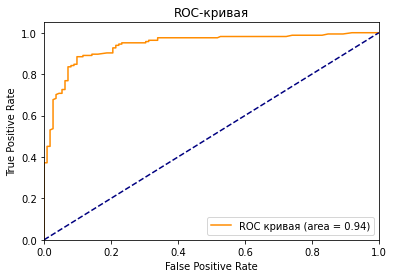

Средняя вероятность: 0.54


In [41]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# строим график
plt.plot(fpr, tpr, color='darkorange',
label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()
print('Средняя вероятность:', round(np.mean(y_proba),4))

In [42]:
print_regression_metrics(y_test, y_pred, y_proba)

f1 = 0.906, recall = 0.884, precision = 0.929, auc = 0.941
confusion_matrix:
[[101  11]
 [ 19 145]]


<AxesSubplot:>

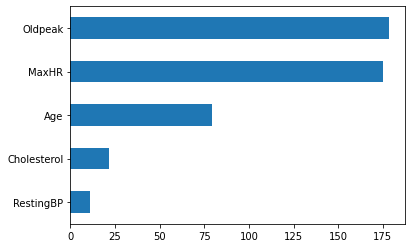

In [25]:
#будем считать новые колонки численными и добавим их в список численных колонок
imp_num = pd.Series(f_classif(hr_processed[nums[:-1]], hr_processed['HeartDisease'])[0], index=nums[:-1])
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [26]:
nums_true = nums[:-1]
nums_true.append('HeartDisease')
nums_true

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']

<AxesSubplot:>

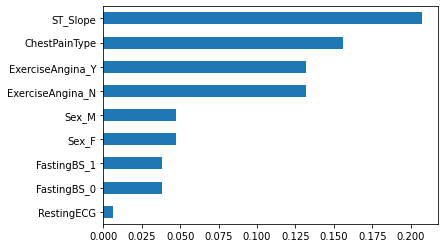

In [27]:
#сделаем еще списки категориальных и бинарных колонок и посмотрим их значимость
cats = hr_processed.drop(nums_true, axis=1).columns
imp_cat = pd.Series(mutual_info_classif(hr_processed[cats], hr_processed['HeartDisease'],
discrete_features =True), index = cats)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# 4. Prognosis

In [394]:
print('Здравствуйте, необходимо ввести свои медцинские данные для оценки риска кардиологического заболевания.',
      'В случае возникновения вопросов с введением данных пользуйтесь справочной таблицей.', sep='\n\n')

Здравствуйте, необходимо ввести свои медцинские данные для оценки риска кардиологического заболевания.

В случае возникновения вопросов с введением данных пользуйтесь справочной таблицей.


In [395]:
input_data = {}
for col in hr.columns[:-1]:
    if col in nums:
        input_data[col] = int(input(f'Введите ваши данные {col}:'))
    else:
        input_data[col] = input(f'Введите ваши данные {col}:')

Введите ваши данные о Age:51
Введите ваши данные о Sex:M
Введите ваши данные о ChestPainType:ATA
Введите ваши данные о RestingBP:125
Введите ваши данные о Cholesterol:140
Введите ваши данные о FastingBS:0
Введите ваши данные о RestingECG:Normal
Введите ваши данные о MaxHR:170
Введите ваши данные о ExerciseAngina:N
Введите ваши данные о Oldpeak:1
Введите ваши данные о ST_Slope:Up


In [396]:
input_data_df = pd.DataFrame(data=input_data, index=[918])

In [397]:
hr_input = hr.append(input_data_df).drop(['HeartDisease'], axis=1)

In [398]:
y_to_pred = preprocessing_data(hr_input).loc[len(hr_input) - 1].values.reshape(1,14)

In [399]:
y_pred = model_extree.predict(y_to_pred)
y_proba = model_extree.predict_proba(y_to_pred)[:,1]

In [400]:
if y_proba[0] > 0.5:
    print(f'У вас высокий кардиологический риск, вероятность заболевания: {y_proba[0]*100}%')
elif 0.3 < y_proba[0] <= 0.5:
    print(f'У вас средний кардиологический риск, вероятность заболевания: {y_proba[0]*100}%')
else:
    print(f'У вас низкий кардиологический риск, вероятность заболевания: {y_proba[0]*100}%')

У вас низкий кардиологический риск, вероятность заболевания: 29.599999999999998%


In [43]:
import pickle
model = pickle.dumps(model_extree)
type(model), type(model_extree)

(bytes, sklearn.ensemble._forest.ExtraTreesClassifier)

In [45]:
with open('C:/Users/Алексей Третьяков/Desktop/ML_rep/heart_project/heart.pkl', 'wb') as output:
       pickle.dump(model_extree, output)

In [46]:
with open('C:/Users/Алексей Третьяков/Desktop/ML_rep/heart_project/heart.pkl', 'rb') as pkl_file:
    regressor_from_file = pickle.load(pkl_file)

regressor_from_file

ExtraTreesClassifier(n_estimators=500, n_jobs=-1, random_state=42)